In [1]:
import numpy as np
import random
import os
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal

from utils.augment import augment
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from utils.deep import preProcess, smoothLabels, oneHot, applyOneHot, evaluate_set
from utils.visualize import showMe, showHistory


%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [11]:
classes = ['Rest', 'Eyebrow','Smile', 'Chew']

batch_size = 32
#input_length = 300
input_length = 100
root_path = 'C:/resources/EMG/'
post_fix = '_1s_augmented'
#post_fix = '_3s'
exclude = ['S011']
exclude_last = ['S001', 'S006', 'S007']
include = ['S001','S003','S010']
train_sessions = []
for subject in os.listdir(root_path):
    if subject not in exclude:
    #if subject in include:
        for session in os.listdir(os.path.join(root_path,subject)):
            if session == 'session_4' and subject in exclude_last:
                continue
            train_sessions.append(os.path.join(root_path,subject, session))
        #print(f"{len(os.listdir(os.path.join(root_path,subject)))} session loaded from subject: {subject}")
print(f"{len(train_sessions)} sessions loaded for training")

records = {}
for c in classes:
    class_data = []
    for session in train_sessions:
        class_data.append(np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True))
    records[c] = np.concatenate(class_data)

    
test_sessions = []
for subject in os.listdir(root_path):
    if subject not in exclude:
        for session in os.listdir(os.path.join(root_path,subject)):
            if session == 'session_4' and subject in exclude_last:
                test_sessions.append(os.path.join(root_path,subject, session))
print(f"{len(test_sessions)} session loaded for testing")



31 sessions loaded for training
3 session loaded for testing


In [3]:
X = np.concatenate((list(records.values())),axis = 0)

# ezt szedd ki
# clip_value = 2000
# X = signal.resample(X, input_length, axis = -1)
# X = np.clip(X, -clip_value, clip_value) 
# X /= clip_value

s = records['Rest'].shape[0]
y = np.concatenate(( np.zeros(s),np.ones(s),np.ones(s)*2,np.ones(s)*3))



#SHUFFLE DATA
c = list(zip(X, y))
random.shuffle(c)
X,y = zip(*c)
X = np.array(X)
y = np.array(y)

y = applyOneHot(y,len(classes))

print(X.shape)
print(y.shape)


(9300, 6, 100)
(9300, 4)


In [4]:
X = np.array([preProcess(s) for s in X])


#AUGMENT
X_aug, y_aug = augment(X, y)

print(X_aug.shape)
print(y_aug.shape)

(18600, 6, 100)
(18600, 4)


In [65]:
def get_dense_model():
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')
    #x = layers.Flatten()(input_layer)

    l2 = 0.0001
   

    x     = layers.Dense(1000,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Flatten()(x)

    x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)


    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(50,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    #x     = layers.Dropout(.1)(x)


    x     = layers.Dense(30,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(10,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [5]:
def get_model():
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')
    #x = layers.Flatten()(input_layer)

    l2 = 0.000001
   
    x     = layers.Conv2D(256, kernel_size=(6,6), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(input_layer)
    x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(1,5))(x)


    x     = layers.Dense(1000,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    #x     = layers.Flatten()(x)

    x     = layers.Dense(500,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)

    x     = layers.Dense(500,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)

    x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)

    x     = layers.Flatten()(x)

    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.1)(x)

    x  
    
    x     = layers.Dense(50,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(20,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [9]:
def get_hyper_model(hp):
    model = keras.Sequential()
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length), name='input')
    x = layers.Flatten()(input_layer)
    l2 = 0.001
    for i in range(hp.Choice('n_layers',[4,6, 10, 20])):
        x     = layers.Dense(hp.Int('dense',min_value=100,max_value=10000,sampling="log"),kernel_regularizer=regularizers.l2(l2))(x)
        x     = layers.BatchNormalization()(x)
        x     = layers.Dropout(hp.Choice('dropout',[0., 0.1]))(x)


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)


    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log"),
        decay_steps=batch_size*10,
        decay_rate=hp.Choice('decay',[0.1,0.9]))


    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    model.summary()
    return model

In [6]:
#model = get_dense_model()
model = get_model()


# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=1000,
#     decay_rate=0.9
#     )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-6, min_delta = 0.0001)
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.000001)

opt = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['categorical_accuracy']
         )


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6, 100, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 100, 256)       9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 100, 256)       1024      
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 20, 256)        0         
_________________________________________________________________
dense (Dense)                (None, 6, 20, 1000)       257000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 20, 1000)       4000      
_________________________________________________________________
dense_1 (Dense)              (None, 6, 20, 500)       

Batch size: 32
Epoch 1/100
524/524 [==============================] - 14s 26ms/step - loss: 1.3968 - categorical_accuracy: 0.3574 - val_loss: 1.2821 - val_categorical_accuracy: 0.4038
Epoch 2/100
524/524 [==============================] - 13s 26ms/step - loss: 1.2871 - categorical_accuracy: 0.3950 - val_loss: 1.2037 - val_categorical_accuracy: 0.4328
Epoch 3/100
524/524 [==============================] - 14s 26ms/step - loss: 1.2243 - categorical_accuracy: 0.4179 - val_loss: 1.1902 - val_categorical_accuracy: 0.4215
Epoch 4/100
524/524 [==============================] - 14s 26ms/step - loss: 1.1989 - categorical_accuracy: 0.4376 - val_loss: 1.1720 - val_categorical_accuracy: 0.4640
Epoch 5/100
524/524 [==============================] - 13s 26ms/step - loss: 1.1804 - categorical_accuracy: 0.4483 - val_loss: 1.1576 - val_categorical_accuracy: 0.4699
Epoch 6/100
524/524 [==============================] - 13s 26ms/step - loss: 1.1681 - categorical_accuracy: 0.4615 - val_loss: 1.1513 - val_

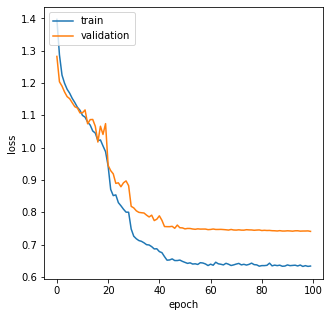

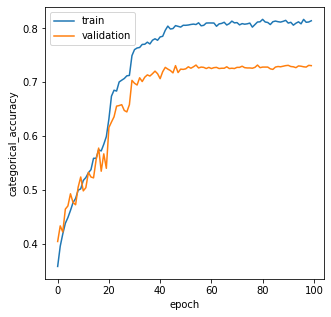

0.7317204475402832


In [7]:
##############################################
############     TRAIN MODEL     #############
##############################################
skf = StratifiedKFold(n_splits=10)
#tf.config.run_functions_eagerly(True)
accs = []
models = []
for train, test in skf.split(X_aug, y_aug.argmax(axis=1)):
  
    X_train = X_aug[train]
    X_test  = X_aug[test]
    y_train = y_aug[train]
    y_test  = y_aug[test]


    #X_train = np.expand_dims(X_train, axis = -1) 
    #X_test  = np.expand_dims(X_test,  axis = -1)

    batch_size = 32 #len(X_train)
    print("Batch size: {}".format(batch_size))

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        batch_size=batch_size,
                        epochs=100,
                        shuffle=True,
                        callbacks = [reduce_lr])

    showHistory(history)      
    try:    
        acc = max(history.history['val_accuracy'])
    except:
        acc = max(history.history['val_categorical_accuracy'])
    accs.append(acc)                       
    models.append(model)
    if acc > 0.9:
        break
    break


model = models[accs.index(max(accs))]
for acc in accs:
    print(acc)

In [ ]:
skf = StratifiedKFold(n_splits=10)
#tf.config.run_functions_eagerly(True)

for train, test in skf.split(X, y.argmax(1)):
  
    X_train = X[train]
    X_test  = X[test]
    y_train = y[train]
    y_test  = y[test]

    #batch_size = 30 #len(X_train)
    print("Batch size: {}".format(batch_size))


    tuner = kt.tuners.RandomSearch(
        get_hyper_model,
        objective='val_accuracy',
        max_trials=100)

    tuner.search(X_train,
                y_train,
                validation_data=(X_test, y_test),
                batch_size=batch_size,
                epochs=20,
                shuffle=True)

    best_model = tuner.get_best_models()[0]
                             
    break
   

In [ ]:
tuner.results_summary()

In [8]:
evaluate_set(model, train_sessions, classes, post_fix)

  0%|          | 0/31 [00:00<?, ?it/s]

Global accuracy: 82.94%
          Accuracy
Subject           
S001     82.333333
S002     79.000000
S003     82.000000
S004     83.750000
S005     85.500000
S006     83.333333
S007     84.333333
S008     84.000000
S009     78.000000
S010     83.750000


In [12]:
evaluate_set(model, test_sessions, classes, post_fix)

  0%|          | 0/3 [00:00<?, ?it/s]

Global accuracy: 39.33%
         Accuracy
Subject          
S001           53
S006           34
S007           31
